In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import random
import seaborn as sns

from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

# %matplotlib notebook
%matplotlib inline

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
def set_seed(i):
    random.seed(i)
    np.random.seed(random.getrandbits(32))

In [3]:
# TODO. Move this to separate file for improved caching

import joblib
import subprocess

# TODO. Get version / last commit id of OCaml simulator and use as cache key
memory = joblib.Memory("/tmp/cpr_graphml_cache", verbose=False)


@memory.cache
def sim(G, **kwargs):
    G = G.copy()
    for k, v in kwargs.items():
        G.graph[k] = v

    # force determinism
    if "seed" not in G.graph:
        G.graph["seed"] = 42

    type_of_node_key = type(list(G.nodes.keys())[0])

    with subprocess.Popen(
        ["_build/default/simulator/bin/graphml_runner.exe"],
        cwd="../../",
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        text=True,
    ) as process:
        for line in nx.generate_graphml(G):
            try:
                process.stdin.write(line)
            except BrokenPipeError as e:
                pass
        out, err = process.communicate()
        G = nx.parse_graphml(out)
        node_labels = {x: type_of_node_key(x) for x in G.nodes.keys()}
        return nx.relabel_nodes(G, node_labels)

In [4]:
def draw(G, size="compute", layout=None):
    size = dict(G.nodes(data=size)).values()
    size = np.array(list(size)) * 1000
    size = np.interp(size, (size.min(), size.max()), (100, 2000))
    return_layout = False
    if not layout:
        layout = nx.spring_layout(G, weight="spring_weight")
        return_layout = True
    nx.draw(G, pos=layout, node_size=size)
    if return_layout:
        return layout


def print_(G):
    for l in nx.generate_graphml(G):
        print(l)

compute 7 [1, 2, 3, 4, 5, 6, 7]


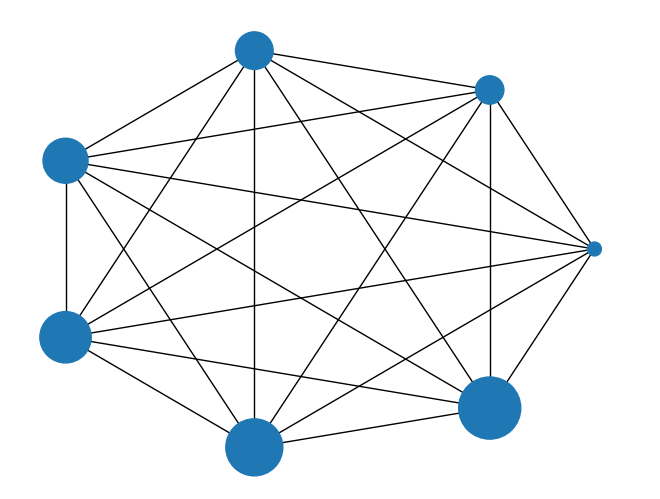

In [29]:
# Mining statistics for the last 7 days before Dec. 12 2022
# from https://www.blockchain.com/explorer/charts/pools
compute = [  # relative hash-rate # blocks mined / pool
    0.24817,  # 271 / Foundry USA
    0.20147,  # 220 / AntPool
    0.15110,  # 165 / F2Pool
    0.13736,  # 150 / Binance Pool
    0.10440,  # 114 / ViaBTC
    0.05311,  # 58  / Braiins Pool
    0.02473,  # 27  / Poolin
    0.01923,  # 21  / BTC.com
    0.01648,  # 18  / Luxor
    0.01465,  # 16  / Mara Pool
    0.00641,  # 7   / Ultimus
    0.00641,  # 7   / SBI Crypto
    0.00366,  # 4   / BTC M4
    0.00275,  # 3   / Titan
    # NaN    # 11  / Unknown
]
assert np.sum(compute) < 1
compute.append(1 - np.sum(compute))

compute = list(range(1, 8))

print("compute", len(compute), compute)

G = nx.complete_graph(len(compute))
G.graph["dissemination"] = "simple"

for i in range(len(compute)):
    G.nodes[i]["compute"] = compute[i]

for a, b in G.edges:
    G.edges[a, b]["delay"] = f"uniform 0.5 1.5"

layout = nx.circular_layout(G)
draw(G, layout=layout)
# print_(G)

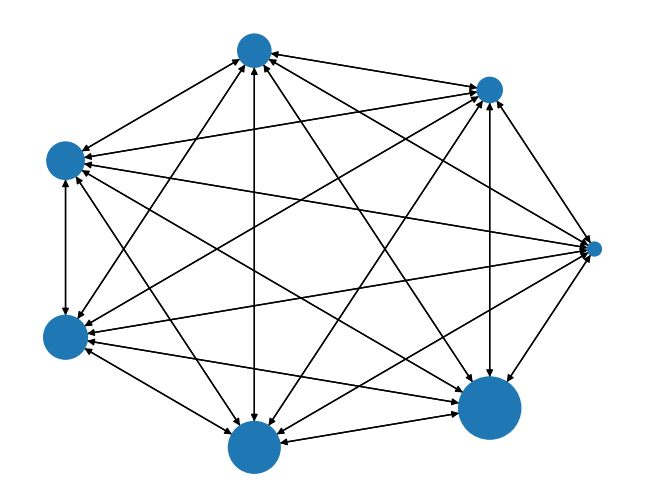

In [30]:
res = sim(G, activation_delay=1, activations=10000, protocol="nakamoto")
draw(res, size="reward", layout=layout)

In [37]:
ks = [2, 4, 8, 16, 32]
protocols = [("nakamoto", 1)]
# protocols += [('ethereum', 1)]
protocols += [(f"bk-{k}-constant", k) for k in ks]
protocols += [(f"tailstorm-{k}-constant-heuristic", k) for k in ks]
protocols += [(f"tailstorm-{k}-discount-heuristic", k) for k in ks]
block_intervals = [
    10
]  # nakamoto/tailstorm/bk blocks, tailstorm summaries (multiples of expected message delay)

# copied from https://stackoverflow.com/a/39513799
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad / np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [40]:
def rows():
    for p, k in protocols:
        for bi in block_intervals:
            for i in range(100):
                yield pd.Series(
                    dict(
                        protocol=p,
                        k=k,
                        block_interval=bi,
                        seed=i,
                    )
                )


def measure(x):
    res = sim(
        G,
        activation_delay=x.block_interval / x.k,
        activations=1000,
        protocol=x.protocol,
        seed=x.seed,
    )
    reward = list(nx.get_node_attributes(res, "reward").values())
    return pd.Series(dict(reward_gini=gini(reward)))


df = pd.DataFrame(rows())
# df = df.sample(frac=1)
df = pd.concat([df, df.parallel_apply(measure, axis=1)], axis=1)

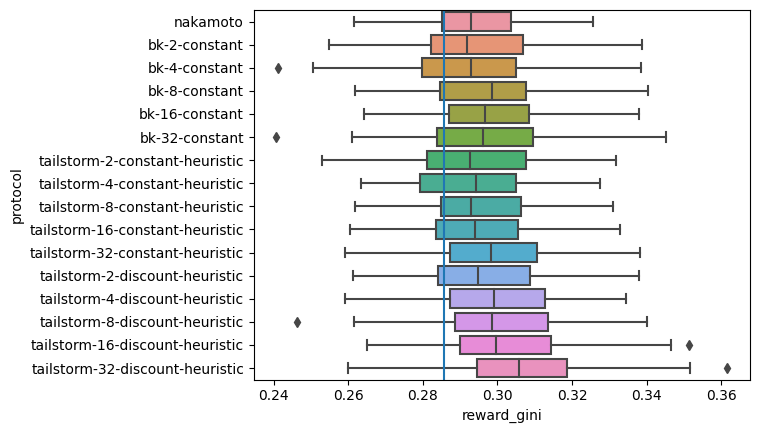

In [41]:
plt = sns.boxplot(data=df, x="reward_gini", y="protocol", orient="h")
plt.axvline(gini(compute))